# Import needed libraries

In [20]:
# base libraries
import numpy as np
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# data and preprocessing libraries
from sklearn.model_selection import train_test_split, GridSearchCV #Train-Test split
from sklearn import preprocessing
from datetime import datetime

# model training libraries
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

# Error evaluation libraries
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import warnings; warnings.simplefilter('ignore')

In [2]:
save_dir = "Images/"

 # 1. Data Loading and Preprocessing

## 1.1. Read in the Dataset

In [3]:
# Define column names as the dataset does not have headers
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
    'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
    'hours_per_week', 'native_country', 'income'
]

# Load the training data
adult_data = pd.read_csv(
    './adult/adult.data',
    header=None, # The data file does not have a header row
    names=column_names,
    sep=',\s+', # Use regular expression to handle possible spaces after commas
    na_values='?' # '?' in the data should be treated as missing values
)

# Load the testing data
adult_test = pd.read_csv(
    './adult/adult.test',
    header=None, # The data file does not have a header row
    names=column_names,
    sep=',\s+', # Use regular expression to handle possible spaces after commas
    na_values='?', # '?' in the data should be treated as missing values
    skiprows=1 # Skip the first row which contains a single label
)

In [4]:
# Print the dimensions of the dataset
print('Dimension: ', adult_data.shape) 
#After ames_housing_data. type tab to see all the available variables 

# Display the head of the dataset
adult_data.head()

Dimension:  (32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 1.2. Checking for Missing Data

In [5]:
# Checking for missing data
missing_data = adult_data.isnull().sum()

# Filtering out only those columns which have missing data
missing_data = missing_data[missing_data > 0]

missing_data

workclass         1836
occupation        1843
native_country     583
dtype: int64

## 1.3. Removing Rows with Missing Values
Although our dataset doesn't have any missing data, we have this code for the code to be generalizable.

In [6]:
# Removing rows with missing values
adult_data_cleaned = adult_data.dropna()

# Checking the shape of the cleaned dataset to confirm the rows were removed
adult_data_cleaned.shape

(30162, 15)

## 1.4. Check for Duplicate Rows

In [7]:
# Check for duplicate rows

print('Number of duplicate rows: ', adult_data_cleaned.duplicated().sum())

Number of duplicate rows:  23


## 1.5. Remove Duplicate Rows

In [8]:
adult_data_cleaned = adult_data_cleaned.drop_duplicates(keep='first')

adult_data_cleaned.shape

(30139, 15)

# 2. Data Visualization
Many of the data are non-numeric; however, studying their correlations matters since we have to ensure we don't have one or a predictor that can explain the income 100% of the time! Thus, we must convert every non-numerical variable into a numerical one to study their correlations.

In [9]:
adult_data_cleaned.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

## 2.1. Inspect Data over Gender

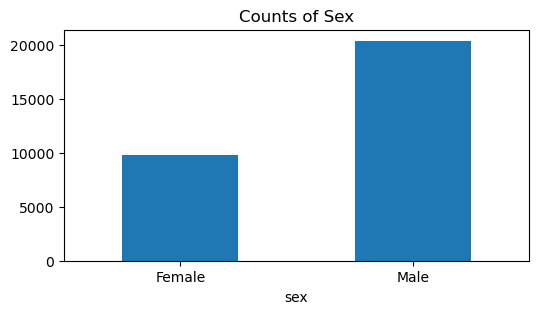

In [12]:
adult_data_cleaned['sex'].value_counts().sort_values().plot(kind='bar', title='Counts of Sex', rot=0, figsize=(6, 3))

# Define the filename using f-string or other appropriate method
filename = 'Counts of Sex.png'

# Save the plots in the specified directory
plt.savefig(save_dir + filename, dpi=300, bbox_inches='tight')

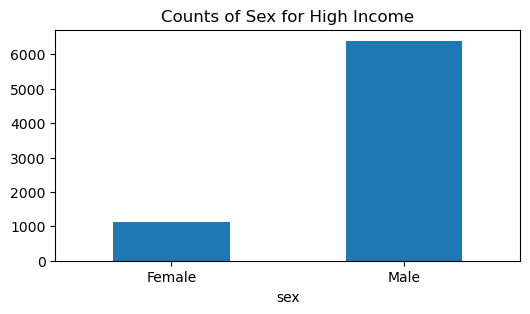

In [13]:
# Plotting the counts of sex for high income
counts = adult_data_cleaned['sex'].where(adult_data_cleaned['income'] == '>50K').value_counts().sort_values()
counts.plot(kind='bar', title='Counts of Sex for High Income', rot=0, figsize=(6, 3))

# Define the filename using f-string or other appropriate method
filename = 'Counts of Sex for High Income.png'

# Save the plots in the specified directory
plt.savefig(save_dir + filename, dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

### Result: Severe imbalance when it comes to dedicating high salary to male vs. female.

## 2.2. Encode Data: Convert All Columns to Numeric

### Incoding everything with integers

In [14]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

def number_encode_features(df):
    """Encode categorical features using LabelEncoder.

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: DataFrame with encoded features.
        dict: Dictionary of encoders for each feature.
    """
    # Create a copy of the DataFrame
    result = df.copy()

    # Dictionary to hold encoders for each column
    encoders = {}

    # Iterate through each column in the DataFrame
    for column in result.columns:
        # Check if the column data type is object (categorical)
        if result.dtypes[column] == np.object_:
            # Create a LabelEncoder for the column
            encoders[column] = preprocessing.LabelEncoder()
            
            # Fill NaN values with 'None' and encode the column
            result[column] = encoders[column].fit_transform(result[column].fillna('None'))
            print(f'Column: {column}, Encoded values: {result[column]}')

    return result, encoders

# Define target column
target_column = 'income'

# Separate target column and features
training_target = adult_data_cleaned[target_column]
training_features = adult_data_cleaned.drop(columns=[target_column])

# Encode features using the function
encoded_training_features, training_encoders = number_encode_features(training_features)

# Concatenate encoded features and target back together
encoded_training_data = pd.concat([training_target, encoded_training_features], axis=1)

# Save the encoded training data
encoded_training_data.to_csv('train_data.csv', index=False, header=False)

# Separate target column and features in the test data
testing_target = adult_test[target_column]
testing_features = adult_test.drop(columns=[target_column])

# Encode features using the function
encoded_testing_features, testing_encoders = number_encode_features(testing_features)

# Concatenate encoded features and target back together for the test data
encoded_testing_data = pd.concat([testing_target, encoded_testing_features], axis=1)

# Save the encoded test data
encoded_testing_data.to_csv('test_features.csv', index=False, header=False)

Column: workclass, Encoded values: 0        5
1        4
2        2
3        2
4        2
        ..
32556    2
32557    2
32558    2
32559    2
32560    3
Name: workclass, Length: 30139, dtype: int64
Column: education, Encoded values: 0         9
1         9
2        11
3         1
4         9
         ..
32556     7
32557    11
32558    11
32559    11
32560    11
Name: education, Length: 30139, dtype: int64
Column: marital_status, Encoded values: 0        4
1        2
2        0
3        2
4        2
        ..
32556    2
32557    2
32558    6
32559    4
32560    2
Name: marital_status, Length: 30139, dtype: int64
Column: occupation, Encoded values: 0         0
1         3
2         5
3         5
4         9
         ..
32556    12
32557     6
32558     0
32559     0
32560     3
Name: occupation, Length: 30139, dtype: int64
Column: relationship, Encoded values: 0        1
1        0
2        1
3        0
4        5
        ..
32556    5
32557    0
32558    4
32559    3
32560    5
Nam

### Shape of the Incoded Data

In [15]:
encoded_training_data.head()

,income,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,<=50K,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,<=50K,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,<=50K,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,<=50K,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,<=50K,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


In [16]:
encoded_testing_data.head()

,income,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,<=50K.,25,4,226802,1,7,4,6,3,2,1,0,0,40,38
1,<=50K.,38,4,89814,11,9,2,4,0,4,1,0,0,50,38
2,>50K.,28,1,336951,7,12,2,11,0,4,1,0,0,40,38
3,>50K.,44,4,160323,15,10,2,6,0,2,1,7688,0,40,38
4,<=50K.,18,3,103497,15,10,4,7,3,4,0,0,0,30,38


## 3. Train a Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Separate features and target
features = encoded_training_data.drop(columns='income')  # Assuming the first column is the target (income)
target = encoded_training_data['income']  # Target column (income)

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create the decision tree classifier
decision_tree = DecisionTreeClassifier(random_state=2024)

# Define the hyperparameter grid to search over
param_grid = {
    'criterion': ['gini', 'entropy'],  # Splitting criteria
    'max_depth': [None, 5, 10, 15, 20],  # Max depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6],  # Minimum samples required to be at a leaf node
}

# Create GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best accuracy achieved
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.2f}")

# Use the best model found by GridSearchCV to predict on the validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the best model on the validation set
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Setting Meaningful Figures
print(f"Validation Set Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_str)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Accuracy: 0.85
Validation Set Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.86      0.95      0.90      4485
        >50K       0.80      0.54      0.64      1543

    accuracy                           0.85      6028
   macro avg       0.83      0.75      0.77      6028
weighted avg       0.84      0.85      0.84      6028



## 3.1. Tree Visualization

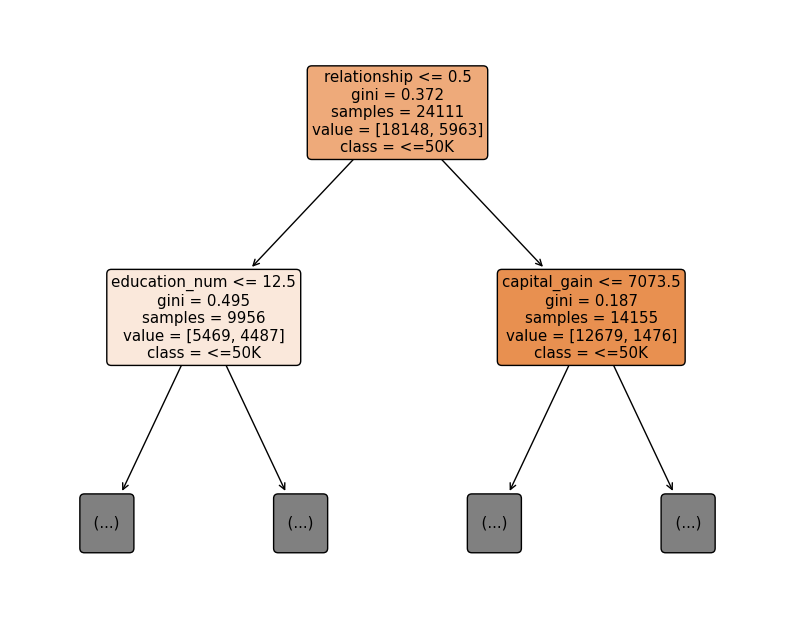

In [26]:
# Set the maximum depth of the tree to 1 to visualize the first splitting rule
plt.figure(figsize=(10, 8))
plot_tree(best_model, max_depth=1, feature_names=X_test.columns, class_names=['<=50K', '>50K'], filled=True, rounded=True)
# Define the filename using f-string or other appropriate method
filename = 'Adult First Tree.png'

# Save the plots in the specified directory
plt.savefig(save_dir + filename, dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## 3.2 Confusion Matrix

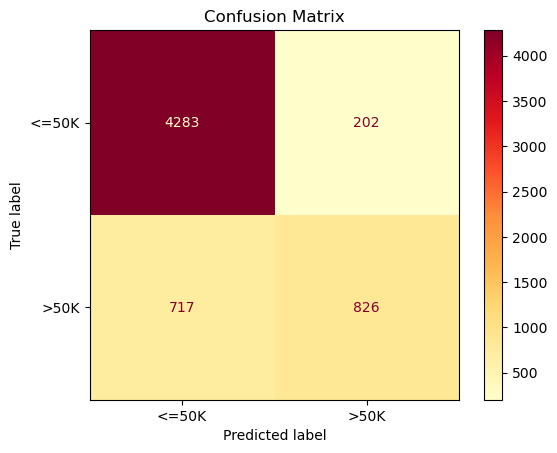

In [27]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

# Plot the confusion matrix display
disp.plot(cmap='YlOrRd')

# Add a title
plt.title("Confusion Matrix")

filename = 'Adult First Confusion Matrix.png'

# Save the plots in the specified directory
plt.savefig(save_dir + filename, dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## 4. Bias Detection

In [28]:
# Assuming `sex` column is the column for gender in `X_test`
sex_column = X_test['sex']

# Get unique groups in the `sex` column
unique_groups = sex_column.unique()

# Iterate through each group
for group in unique_groups:
    # Filter data based on the group
    group_indices = sex_column == group
    group_features = X_test[group_indices]
    group_target = y_test[group_indices]
    
    # Predict outcomes for the group
    group_pred = best_model.predict(group_features)
    
    # Calculate performance metrics
    accuracy = accuracy_score(group_target, group_pred)
    classification_report_str = classification_report(group_target, group_pred)
    
    # Print the performance metrics for the group
    print(f"Group: {group}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report_str)
    print()

Group: 0
Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.94      0.98      0.96      1730
        >50K       0.76      0.50      0.61       213

    accuracy                           0.93      1943
   macro avg       0.85      0.74      0.78      1943
weighted avg       0.92      0.93      0.92      1943


Group: 1
Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.81      0.94      0.87      2755
        >50K       0.81      0.54      0.65      1330

    accuracy                           0.81      4085
   macro avg       0.81      0.74      0.76      4085
weighted avg       0.81      0.81      0.80      4085




### Debiasing Over Gender: Oversample the Minority Group

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample

# Define the parameter grid
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the decision tree model
model = DecisionTreeClassifier(random_state=2024)

# Set up GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Identify the males who earn <=50K income
males_low_income = encoded_training_data[(encoded_training_data['sex'] == 1) & (encoded_training_data['income'] == '<=50K')]

# Calculate the size of the males earning <=50K income
males_low_income_size = len(males_low_income)
print("Size of males earning <=50K income:", males_low_income_size)

# Oversample the males who earn <=50K income
oversampled_males_low_income = resample(
    males_low_income,
    replace=True,  # Sample with replacement to perform oversampling
    n_samples=males_low_income_size * 2,  # Double the size of the group
    random_state=42  # For reproducibility
)

# Combine the oversampled males with the original training data
balanced_data = pd.concat([encoded_training_data, oversampled_males_low_income])

# Shuffle the balanced data (optional but recommended)
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target from the balanced data
X_balanced = balanced_data.drop(columns=['income'])
y_balanced = balanced_data['income']

# Split the balanced data into training and validation sets
X_balanced_train, X_balanced_test, y_balanced_train, y_balanced_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Perform hyperparameter tuning with GridSearchCV
grid_search.fit(X_balanced_train, y_balanced_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters
print("Best parameters:", best_params)

# Make predictions using the best model on the test data
y_pred = best_model.predict(X_balanced_test)

# Calculate the accuracy
accuracy = accuracy_score(y_balanced_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Calculate and print the classification report
classification_report_str = classification_report(y_balanced_test, y_pred)
print("Classification Report on test data:")
print(classification_report_str)

Size of males earning <=50K income: 13972
Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy: 0.92
Classification Report on test data:
              precision    recall  f1-score   support

       <=50K       0.94      0.97      0.96     10146
        >50K       0.76      0.58      0.66      1471

    accuracy                           0.92     11617
   macro avg       0.85      0.78      0.81     11617
weighted avg       0.92      0.92      0.92     11617



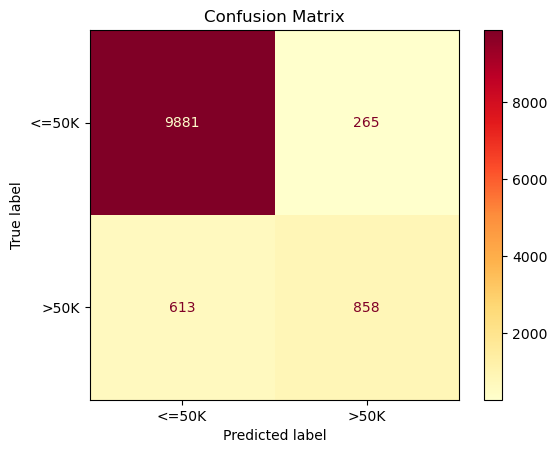

In [30]:
# Calculate the confusion matrix
cm = confusion_matrix(y_balanced_test, y_pred)

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

# Plot the confusion matrix display
disp.plot(cmap='YlOrRd')

# Add a title
plt.title("Confusion Matrix")

filename = 'Adult Second Confusion Matrix.png'

# Save the plots in the specified directory
plt.savefig(save_dir + filename, dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

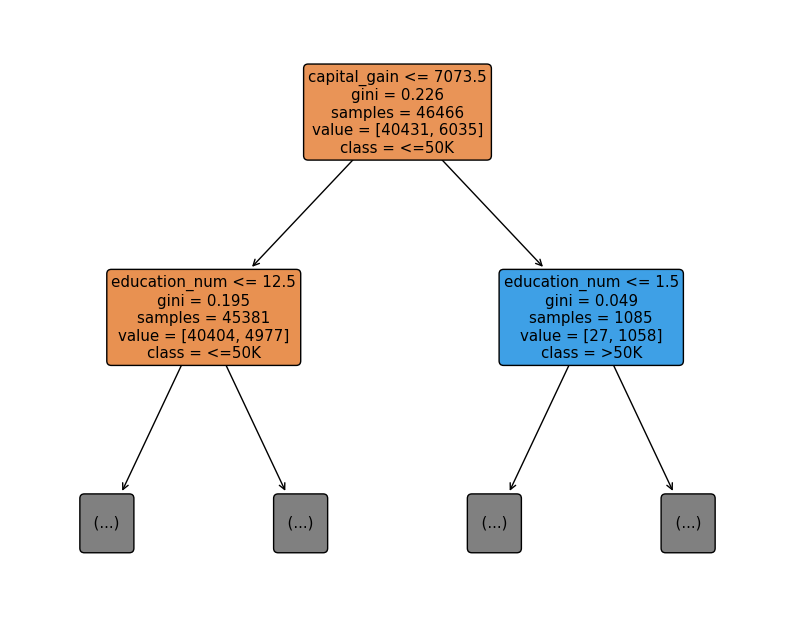

In [31]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Set the maximum depth of the tree to 1 to visualize the first splitting rule
plt.figure(figsize=(10, 8))
plot_tree(best_model, max_depth=1, feature_names=X_balanced.columns, class_names=['<=50K', '>50K'], filled=True, rounded=True)

filename = 'Adult Second Tree.png'

# Save the plots in the specified directory
plt.savefig(save_dir + filename, dpi=300, bbox_inches='tight')

plt.show()